## Pair Programming Intro Decision Tree

In [30]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV


# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')
pd.options.display.max_columns = None

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).
En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:


Preparamos los datos

In [31]:
df = pd.read_csv('../Datos/vinos_encoding_map_map.csv', index_col = 0)
df.head(2)

,id,year_birth,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,mnt_total_sin_vino,mntwines_sin_cero,mnt_wines_box,education_enc,marital_status_enc
0,5524,1957,0.235696,0,0,0.307039,635,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.51089,-0.550785,0.693904,2.011116,635.0,14.026740,2,1
1,2174,1954,-0.235454,1,1,-0.383664,11,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.56872,-1.166125,-0.130463,-0.845274,11.0,3.141178,2,1


Separamos nuestro dataframe en X y Y


In [32]:
X = df.drop(["mnt_wines_box", 'mntwines_sin_cero', 'mntwines', 'id'], axis = 1)
y = df["mnt_wines_box"]

Dividimos nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
#Se crea el objeto del modelo

arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

Mostramos nuestro árbol sin ningún límite en hiperparámetros:

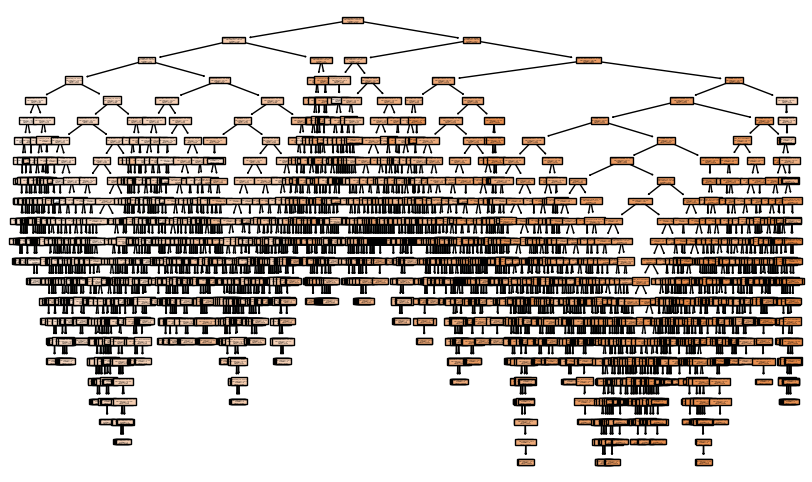

In [35]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

Seleccionamos hiperparámetros:

In [36]:
#debemos poner en nuestro modelo una profudidad máxima de 5. 
max_features = np.sqrt(len(x_train.columns))
max_features

4.242640687119285

In [37]:
# max depth

print(arbol.tree_.max_depth)

22


In [38]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [39]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df_metricas = pd.DataFrame(resultados)
    df_metricas["modelo"] = tipo_modelo
    return df_metricas

In [40]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,1.386579e+00,4.547270e+00,2.132433e+00,0.813975,test,Decision Tree I
1,1.115179e-18,4.126993e-34,2.031500e-17,1.000000,train,Decision Tree I


Observamos que nuestro modelo nos arroja un 1.0 en R2 por lo que concluimos que tienen overfitting. En este caso, nuestro modelo se estaría aprendiendo de memoria los datos de entrenamiento y no sería capaz de hacer buenas predicciones fuera de ese set de datos, así que iniciaremos el proceso para reducir la profundidad en un segundo modelo de decision tree.

In [41]:
# definimos un diccionario con los hiperparámetros que queremos modificar y los valores que podrían ajustarse

param = {"max_depth": [2,4,6,7,8,9], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo.
        "max_features": [1,2,3,4,5],# calculamos en celdas anteriores, pondremos como límite el 5. 
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


Iniciamos el modelo con GridSearch para encontrar el mejor modelo.

In [42]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # los parámetros que definimos en la celda anterior
            cv=10, # crossvalidation  
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [43]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 7, 8, 9],
                         'max_features': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [44]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 8, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=9, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

In [45]:
# predicciones ahora con el mejor modelo


y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [54]:
#llamamos a la función para poder visualizar las métricas del modelo nuevo generando un dataframe 

dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision Tree II")
dt_results2


,MAE,MSE,RMSE,R2,set,modelo
0,1.517295,3.836967,1.958818,0.843033,test,Decision Tree II
1,1.228952,2.624395,1.619998,0.888851,train,Decision Tree II


Lo mostramos gráficamente:

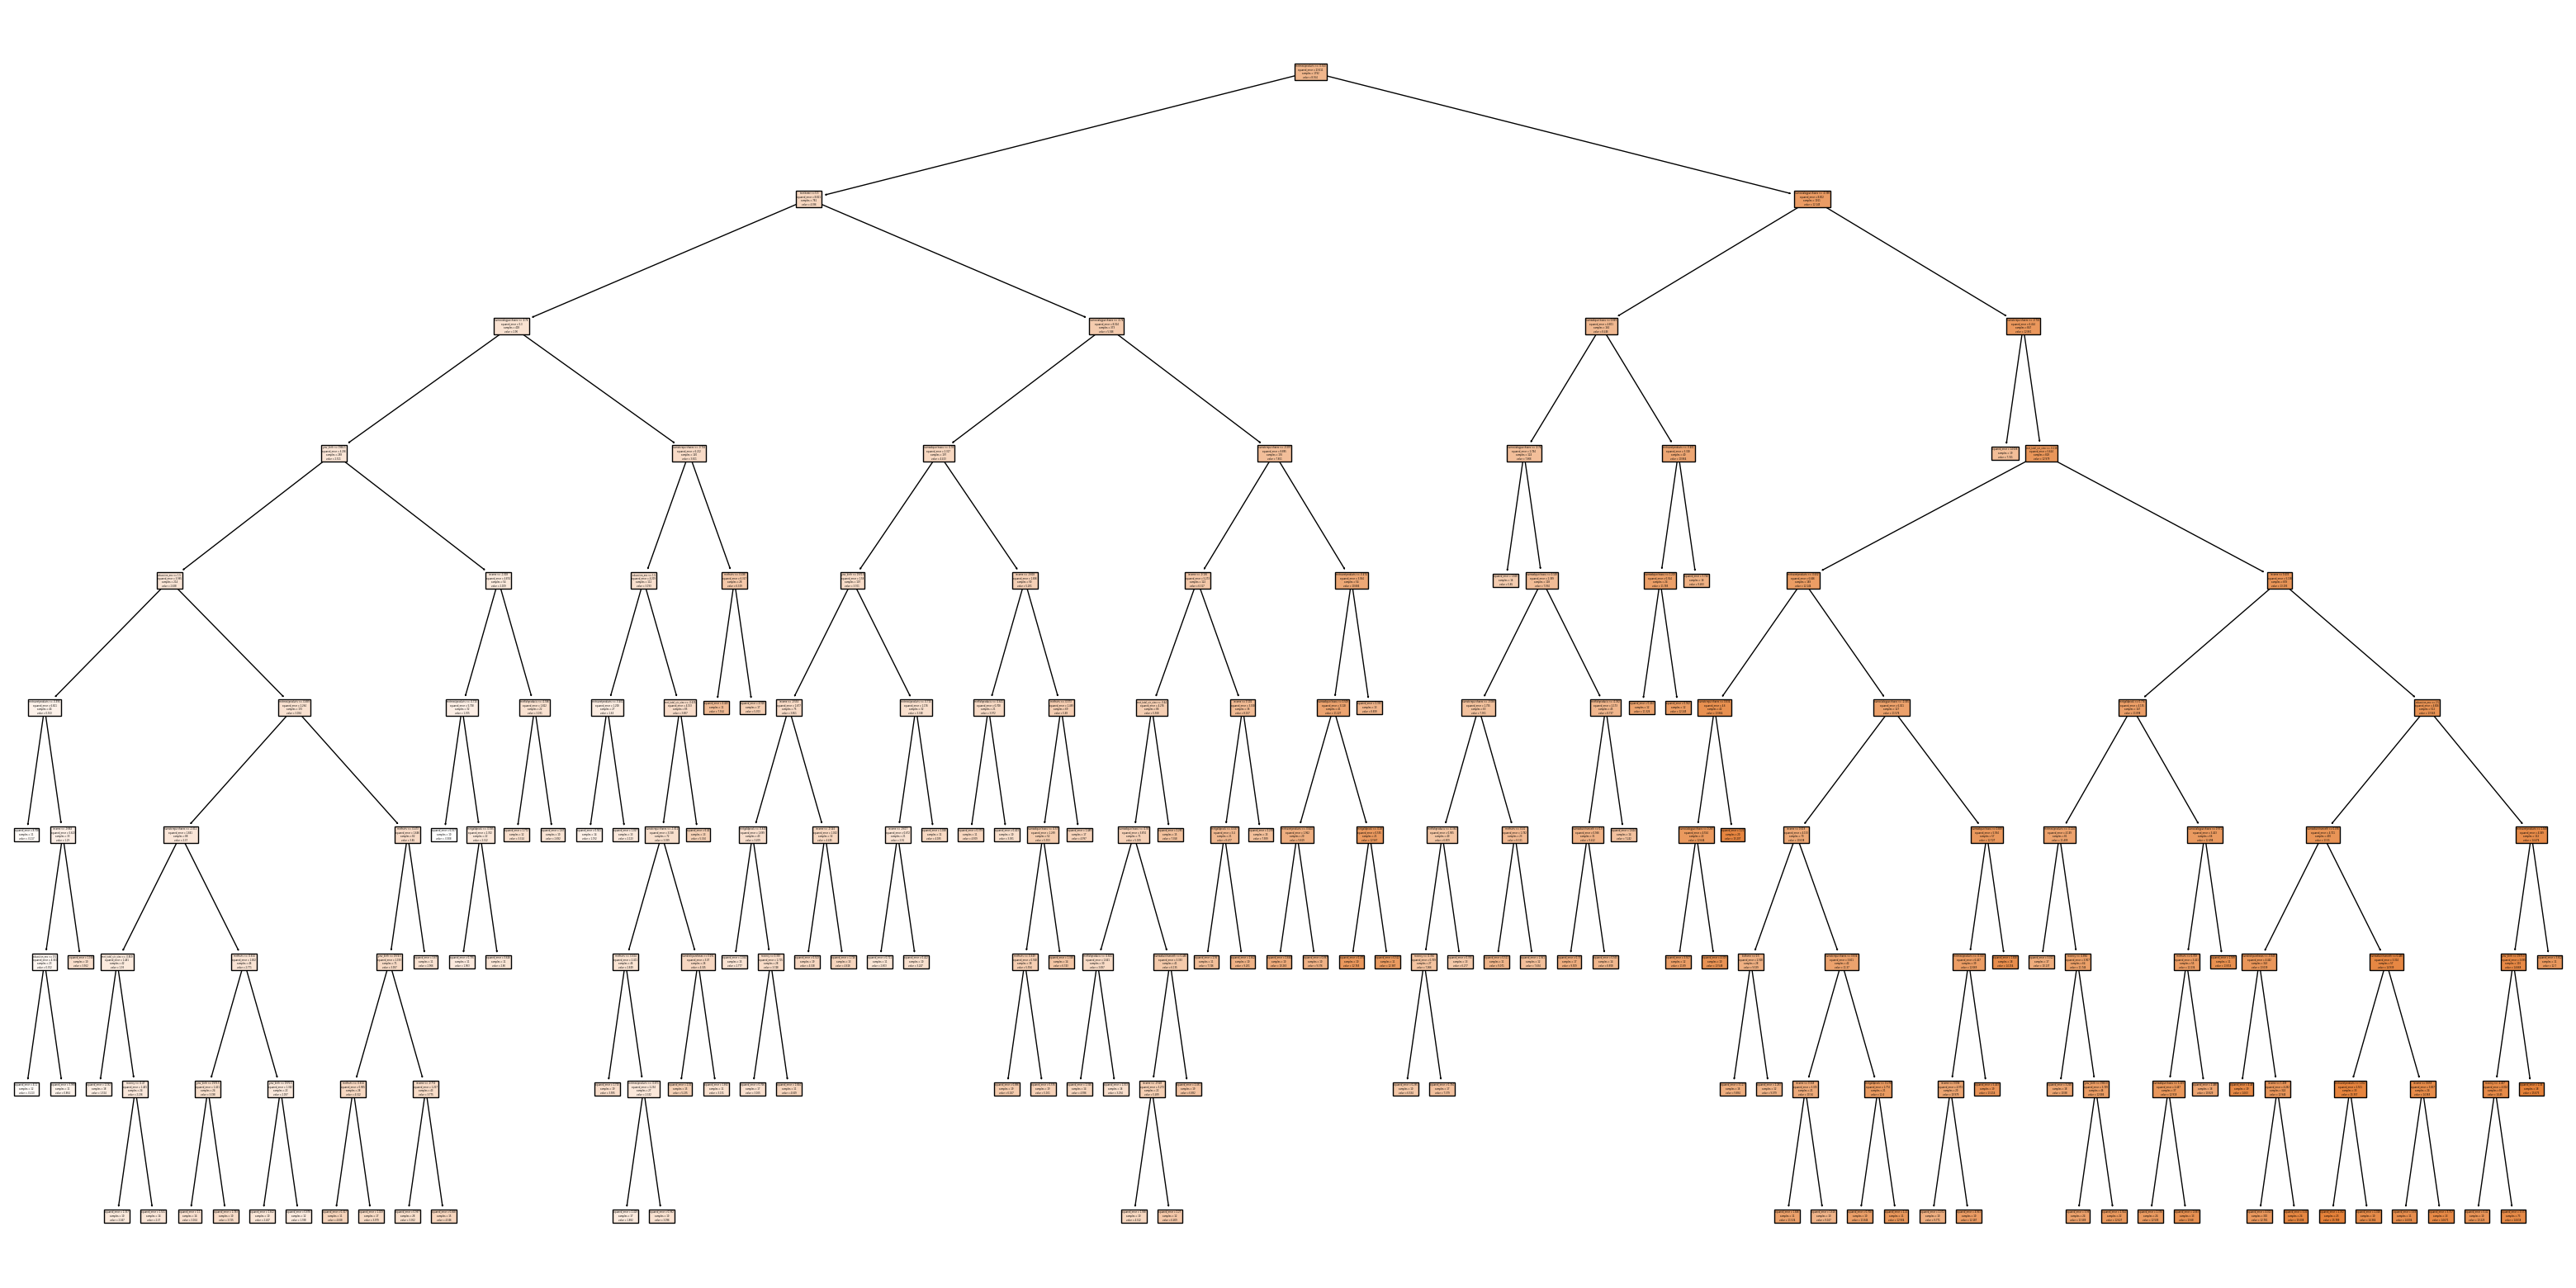

In [55]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [56]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.386579e+00,4.547270e+00,2.132433e+00,0.813975,test,Decision Tree I
1,1.115179e-18,4.126993e-34,2.031500e-17,1.000000,train,Decision Tree I
0,1.517295e+00,3.836967e+00,1.958818e+00,0.843033,test,Decision Tree II
1,1.228952e+00,2.624395e+00,1.619998e+00,0.888851,train,Decision Tree II


Traemos las métricas obtenidas con el método de regresión lineal para agregarlas al dataframe con las métricas de nuestros dos modelos de decision tree para poder compararlas y ver qué modelo es el adecuado.

In [57]:

df_linear_results = pd.read_csv("../Datos/vinos_regresion.csv", index_col = 0)
df_linear_results


,MAE,MSE,RMSE,R2,set,modelo
0,1.636986,4.687012,2.164951,0.808258,test,Linear Regresion
1,1.547348,4.754429,2.180465,0.798639,train,Linear Regresion


In [58]:
# concatenamos todos los resultados

df_DT_LR_results = pd.concat([df_linear_results, df_decision_results], axis = 0)
df_DT_LR_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.636986e+00,4.687012e+00,2.164951e+00,0.808258,test,Linear Regresion
1,1.547348e+00,4.754429e+00,2.180465e+00,0.798639,train,Linear Regresion
0,1.386579e+00,4.547270e+00,2.132433e+00,0.813975,test,Decision Tree I
1,1.115179e-18,4.126993e-34,2.031500e-17,1.000000,train,Decision Tree I
0,1.517295e+00,3.836967e+00,1.958818e+00,0.843033,test,Decision Tree II
1,1.228952e+00,2.624395e+00,1.619998e+00,0.888851,train,Decision Tree II


Conclusiones:

* Podemos observar que las métricas obtenidas del segundo modelo de decision tree (Decision Tree II) son mucho mejores que las del primer modelo e incluso mejor que las obtenidas en el modelo de regresión lineal.
* Con respecto al MAE, el MSE y RMSE, vemos que los valores en general están bastante cerca de 0, lo que nos indica que nuestro modelo es bueno, es decir, que comente pocos errores en las predicciones. 
* Adicionalmente el valor de RMSE es un valor también muy bajo, lo que nos indica que nuestro modelo se equivoca de media por un valor bastante bajo.

In [51]:
# Guardamos el dataframe resultante en un archivo csv

df_DT_LR_results.to_csv("../Datos/vinos_LR_DT.csv")

Extraemos la importancia de cada variable, las que nos ayudan más a predecir las ventas de vino 

In [52]:

# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,mntmeatproducts,0.712409
12,numcatalogpurchases,0.107452
3,teenhome,0.046198
13,numstorepurchases,0.043535
1,income,0.025011
11,numwebpurchases,0.019385
16,education_enc,0.009996
8,mntsweetproducts,0.009327
15,mnt_total_sin_vino,0.006726
14,numwebvisitsmonth,0.005831


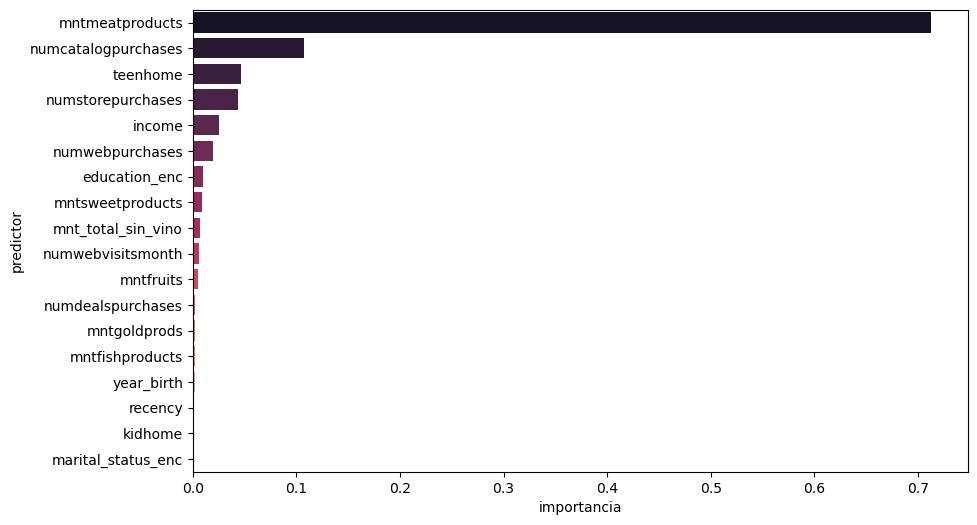

In [53]:

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="rocket");
plt.show()

Podemos observar que nuestra variable de venta de productos de carne es la variable que más importancia tiene en el momento de predecir la compra de vino por una diferencia muy amplia sobre el resto de nuestras variables, lo cual puede indicar que el comportamiento de compra de nuestros clientes va ligado entre la compra de vino y la compra de carne dentro de nuestro establecimiento, esta información puede ser útil para el propietario ya que podría implementar estrategias de venta que incluyan estos dos productos dependiendo de las ventas que decida impulsar.